<a href="https://colab.research.google.com/github/rohitkyadv/Digital-Image-Processing-Neural-Networks/blob/main/FinalProjecCS_504t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements

In [ ]:
import time                           # used for timestamp and random seed
timestamp = int(time.time())          # get time in seconds
import numpy as np
np.random.seed(timestamp)             # seed random number generator
timestamp = str(timestamp)            # string timestamp used for output files
print ('Timestamp: ' + timestamp)
from google.colab import drive
import os                             # used for file manipulation
import matplotlib.pyplot as plt
from keras.models import Model
from keras import layers
from keras.utils import plot_model    # used for model visualization
from keras.callbacks import Callback  # used to test model during training
import scipy.misc as im               # used to write out imagesƒ
from keras import backend as K        # used for custom metrics (JI and DSC)
import tensorflow as tf

def imconvert(a):                     # converts from 0-12 one hot encoding to 0-252 grayscale image
    return np.where(a)[2].reshape(300,400)*21
                                      # path to working directory
path = '/content/gdrive/My Drive/digital image processing CS 504'

Timestamp: 1557486922


In [ ]:
drive.mount('/content/gdrive')        # mount google drive for file reading and writing

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir(path)                        # change directory to working directory

## Loading Dataset

In [ ]:
                                      # xtest and ytest are arrays of 3 images selected from testing dataset for visualizing output during training
xtest = [np.load('data/x50.npy')[n*12].reshape((1,300,400,3)) for n in range(3)]
ytest = [np.load('data/y50.npy')[n*12].reshape((1,300,400,13)) for n in range(3)]

In [ ]:
                                      # image dataset has been preprocessed and written to .npy files
                                      # could not use one file because not enough RAM to read it
                                      # there are 50 input files and 50 output files
                                      # each file contains 100 images
def training_data_generator():        # this generator will be used by keras to get the training set 10 images at a time
    while True:                       # generator crashes the program if it stops so loop forever
        for n in range(35):           # training set is 70% of files
            x = np.load('data/x' + str(n+1) + '.npy')
            y = np.load('data/y' + str(n+1) + '.npy')
            #yield x, y               # originally returned images 100 at a time but this used 100GB of GPU VRAM
            bs = 10                   # batch size is 10 because this uses 10 GB of GPU VRAM 
            for m in range(int(100/bs)):
                yield x[m*bs:(m+1)*bs], y[m*bs:(m+1)*bs]

In [ ]:
def validation_data_generator():      # this generator will be used by keras to get the validation set 10 images at a time
    while True:
        for n in range(35,45):        # validation set is next 20% of files
            x = np.load('data/x' + str(n+1) + '.npy')
            y = np.load('data/y' + str(n+1) + '.npy')
            #yield x, y
            bs = 10
            for m in range(int(100/bs)):
                yield x[m*bs:(m+1)*bs], y[m*bs:(m+1)*bs]

In [ ]:
def testing_data_generator():         # this generator will be used by keras to get the testing set 10 images at a time
    while True:
        for n in range(45,50):        # testing set is last 10% of files
            x = np.load('data/x' + str(n+1) + '.npy')
            y = np.load('data/y' + str(n+1) + '.npy')
            #yield x, y
            bs = 10
            for m in range(int(100/bs)):
                yield x[m*bs:(m+1)*bs], y[m*bs:(m+1)*bs]

## Defining Model Architecture

In [ ]:
hdim = 300                            # image height
wdim = 400                            # image width
                                      # had to adjust network size to not use too much GPU VRAM
stridesy = [5,5,4]                    # how much to downsample image height after each encoder (MaxPooling2D)
stridesx = [5,5,4]                    # how much to downsample image  width after each encoder (MaxPooling2D)
                                      # at beginning, image is 300x400
                                      # after  first encoder, image is downsampled 1/5 or 60x80
                                      # after second encoder, image is downsampled 1/5 or 12x16
                                      # after  third encoder, image is downsampled 1/4 or 3x4
                                      # before each decoder, image is upsampled the reverse of before
numEncoders = len(stridesy)           # 3 encoders
numConvPerEncoder = 2                 # 2 convolutional layers per encoder
numCenterLayers = 1                   # 1 convolutional layer in center between encoders and decoders
numDecoders = numEncoders             # 3 decoders
numConvPerDecoder = 2                 # 2 convolutional layers per decoder

down = []                             # this array will hold outputs of encoders to be connected to decoders to preserve spatial data
                                      # input layer defines input shape and is saved for constructing model at the end
inputLayer = layers.Input(shape=(hdim,wdim,3))
                                      # lambda layer divides by 255 to convert from 0-255 int pixel data to 0-1 float input to the network
layer = layers.Lambda(lambda x: x/255)(inputLayer)
                                      # convolutional layer with 3x3 kernel and 32 channels output and no reduction in image size because of padding
layer = layers.Conv2D(32, (3, 3), padding='same')(layer)
                                      # output is normalized
layer = layers.BatchNormalization()(layer)
                                      # then rectified linear unit function is applied
layer = layers.Activation('relu')(layer)
                                      # convolution, normalization, and activation are part of one "convolutional layer"

for a in range(numEncoders):          # this loop will create multiple encoders
    for b in range(numConvPerEncoder):# this loop will create multiple convolutional layers per encoder
                                      # kernel size is 5x5 this time
        layer = layers.Conv2D(32, (5, 5), padding='same')(layer)
        layer = layers.BatchNormalization()(layer)
        layer = layers.Activation('relu')(layer)
    down.append(layer)                # save this layer for connecting to corresponding decoder later
                                      # downsample using Max Pooling
    layer = layers.MaxPooling2D((stridesy[a], stridesx[a]))(layer)

for a in range(numCenterLayers):      # this loop will make convolutional layers between the encoders and decoders
                                      # kernel is 3x3
    layer = layers.Conv2D(32, (3, 3), padding='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Activation('relu')(layer)

for a in range(numDecoders):          # this loop will create multiple decoders
                                      # upsample using kears Up Sampling layer
    layer = layers.UpSampling2D((stridesy[numDecoders-a-1], stridesx[numDecoders-a-1]))(layer)
    #layer = layers.Add()([down[numDecoders-a-1], layer])
                                      # concatenate output of upsampling layer with outputs of corresponding encoder
    layer = layers.merge.concatenate([down[numDecoders-a-1], layer], axis=3)
    for b in range(numConvPerDecoder):# this loop will create multiple convolutional layers per decoder
                                      # kernel is 5x5
        layer = layers.Conv2D(32, (5, 5), padding='same')(layer)
        layer = layers.BatchNormalization()(layer)
        layer = layers.Activation('relu')(layer)
                                      # final convolutional layer gives only 13 ouputs and is sigmoid for classification
final = layers.Conv2D(13, (3, 3), padding='same', activation="sigmoid")(layer)
                                      # create model from layers
model = Model(inputs=inputLayer, outputs=final)
                                      # model is complete 

## Visualizing Model

In [ ]:
os.chdir(path)                        # go to working directory
if not os.path.exists('model' + timestamp):
    os.makedirs('model' + timestamp)  # create new directory for this output
os.chdir('model' + timestamp)         # go to new directory
                                      # use keras plot_model to get graph of model and write it to .png
plot_model(model, to_file='modelViz' + timestamp + '.png', show_shapes=True)

for n in range(3):                    # also save test image input and expected output for comparison to model outputs
    plt.imsave('input' + str(n+1) + '.png', xtest[n][0])
    plt.imsave('target' + str(n+1) + '.png', imconvert(ytest[n][0]), cmap='nipy_spectral')

## Partially-Trained Outputs

In [ ]:
class Callbacks(Callback):            # this class is used to save model outputs and weights during training to examine progress
    def on_train_begin(self, logs={}):
        self.historyAccuracy = []
        self.historyJaccard = []
        self.historyDice = []
        self.historyLoss = []
                                      # this method is called by keras at beginning of epoch
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch = epoch            # save epoch number for file organization
        if not os.path.exists('model' + timestamp + '/epoch' + str(self.epoch + 1)):
                                      # create new folder for epoch
            os.makedirs('model' + timestamp + '/epoch' + str(self.epoch + 1))
        return
                                      # this method is called by keras at end of batch
    def on_batch_end(self, batch, logs):
                                      # save metrics for plotting
        self.historyAccuracy.append(logs['acc'])
        self.historyJaccard.append(logs['jaccard_distance'])
        self.historyDice.append(logs['dice_coef'])
        self.historyLoss.append(logs['loss'])
        if not os.path.exists('model' + timestamp + '/epoch' + str(self.epoch+1) + '/batch' + str(batch+1)):
                                      # create new folder for batch 
            os.makedirs('model' + timestamp + '/epoch' + str(self.epoch+1) + '/batch' + str(batch+1))
        for n in range(3):            # save model outputs for each test image
            plt.imsave('model' + timestamp + '/epoch' + str(self.epoch+1) + '/batch' + str(batch+1) + '/output' + str(n+1) + '.png', np.argmax(model.predict(xtest[n]), axis=3)[0]*21, cmap='nipy_spectral')
        model.save_weights('model' + timestamp + '/epoch' + str(self.epoch+1) + '/batch' + str(batch+1) + '/weightse' + str(self.epoch+1) + 'b' + str(batch+1) + '.h5')
        return

## Custom Evaluation Metrics

In [ ]:
                                       # jaccard distance also known as intersection over union
def jaccard_distance(y_true, y_pred, smooth=1):
    yintersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    ysum = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
                                       # smooth is to avoid divide by zero
    jac = (yintersection + smooth) / (ysum - yintersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X| + |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    ret = (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    return ret

## Compiling Model

In [ ]:
                                      # compile model with categorical crossentropy training evaluation metric
model.compile(loss='categorical_crossentropy',
              optimizer='adam',       # optimizer
              metrics=['accuracy',
                       jaccard_distance,
                       dice_coef
                      ])              # report accuracy during training

## Training Model

In [ ]:
# Train model on training data
callbacks = Callbacks()               # instance of callbacks class
                                      # create data generators
training_generator = training_data_generator()
validation_generator = validation_data_generator()
os.chdir(path)                        # go to working directory before callbacks
                                      # previously tried all training data at once but ran out of RAM
#history = model.fit(xTrain, yTrain, batch_size=1, epochs=1, verbose=1)#, callbacks=[histories])
                                      # fit model on data from generators 10 images per batch
history = model.fit_generator(training_generator,
                                      # 3500 images 10 images at a time is 350 steps
                              steps_per_epoch=350,
                              validation_data=validation_generator,
                                      # 1000 images 10 images at a time is 100 steps
                              validation_steps=100,
                                      # train for 5 epochs because it takes 30 minutes
                              epochs=5,
                                      # output progress bar and accuracies and losses
                              verbose=1,
                                      # give callbacks class for callbacks methods
                              callbacks=[callbacks])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
  2/350 [..............................] - ETA: 57:02 - loss: 2.4115 - acc: 0.2443 - jaccard_distance: 0.2003 - dice_coef: 0.3715  

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.209198). Check your callbacks.
  % delta_t_median)


350/350 [==============================] - 353s 1s/step - loss: 0.4276 - acc: 0.8789 - jaccard_distance: 0.7988 - dice_coef: 0.8967 - val_loss: 0.2418 - val_acc: 0.9240 - val_jaccard_distance: 0.8641 - val_dice_coef: 0.9295
Epoch 2/5
350/350 [==============================] - 313s 893ms/step - loss: 0.1760 - acc: 0.9439 - jaccard_distance: 0.8495 - dice_coef: 0.9206 - val_loss: 0.1540 - val_acc: 0.9508 - val_jaccard_distance: 0.8047 - val_dice_coef: 0.8865
Epoch 3/5
  1/350 [..............................] - ETA: 3:28 - loss: 0.1576 - acc: 0.9480 - jaccard_distance: 0.8469 - dice_coef: 0.9170

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.703096). Check your callbacks.
  % delta_t_median)


350/350 [==============================] - 314s 898ms/step - loss: 0.1300 - acc: 0.9581 - jaccard_distance: 0.8415 - dice_coef: 0.9104 - val_loss: 0.1283 - val_acc: 0.9587 - val_jaccard_distance: 0.7746 - val_dice_coef: 0.8599
Epoch 4/5
350/350 [==============================] - 314s 896ms/step - loss: 0.1095 - acc: 0.9642 - jaccard_distance: 0.8390 - dice_coef: 0.9059 - val_loss: 0.1085 - val_acc: 0.9644 - val_jaccard_distance: 0.8328 - val_dice_coef: 0.9032
Epoch 5/5
350/350 [==============================] - 313s 895ms/step - loss: 0.0964 - acc: 0.9681 - jaccard_distance: 0.8345 - dice_coef: 0.9008 - val_loss: 0.0936 - val_acc: 0.9693 - val_jaccard_distance: 0.8286 - val_dice_coef: 0.8972


## Visualizing Training Performance

In [ ]:
print (history.history)

{'val_loss': [0.24181036829948424, 0.15404117338359355, 0.1283179508149624, 0.108474280834198, 0.0935811846703291], 'val_acc': [0.9240091460943222, 0.9508279317617416, 0.9586505568027497, 0.9644392913579941, 0.9693429833650589], 'val_jaccard_distance': [0.8641433691978455, 0.804661015868187, 0.77459587931633, 0.8327754110097885, 0.8286386865377426], 'val_dice_coef': [0.9295208036899567, 0.886543675661087, 0.8598988753557205, 0.9032292413711548, 0.8971802586317063], 'loss': [0.42755917791809356, 0.17599499234131405, 0.12999766758510045, 0.10951262735894748, 0.09644429370760918], 'acc': [0.8789377029240132, 0.9439491472925459, 0.9580725365025656, 0.9641599845886231, 0.9680726628644126], 'jaccard_distance': [0.7988071884427752, 0.8494873947756632, 0.8415469741821289, 0.8389870880331312, 0.8345357535566602], 'dice_coef': [0.8967378244229726, 0.9205786422320774, 0.9104018817629133, 0.9058863316263471, 0.900786657503673]}


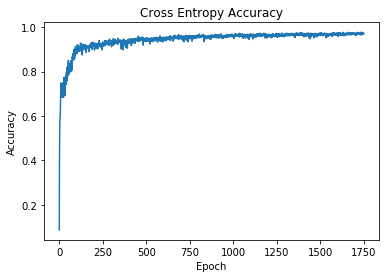

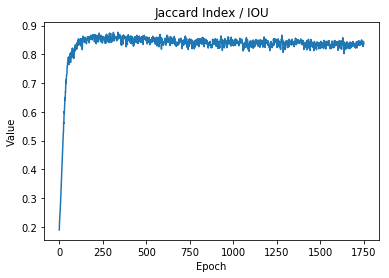

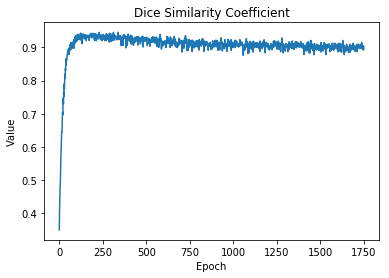

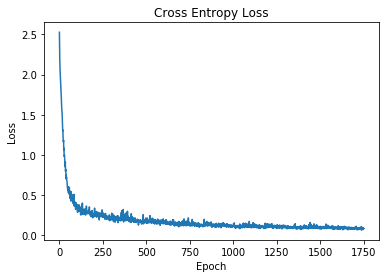

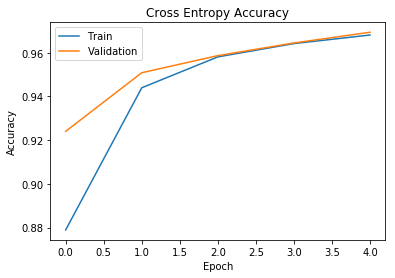

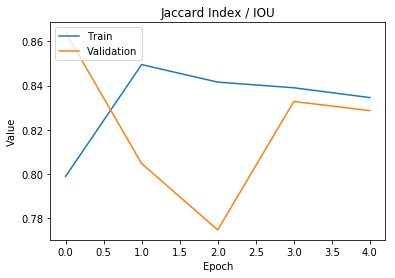

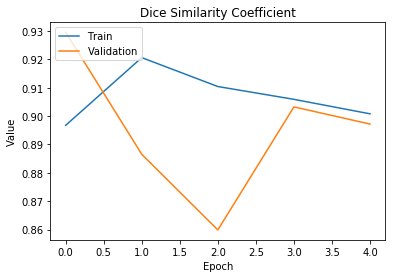

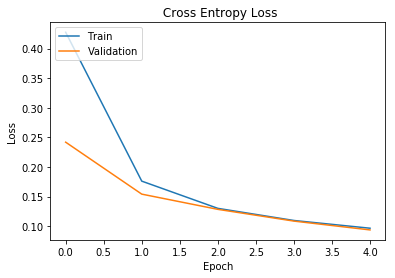

In [ ]:
                                     # plot training & validation accuracy values
plt.plot(callbacks.historyAccuracy)
plt.title('Cross Entropy Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('model' + timestamp + 'batchAcc' + timestamp + '.png', bbox_inches='tight')
plt.show()

                                      # plot training & validation jaccard index values
plt.plot(callbacks.historyJaccard)
plt.title('Jaccard Index / IOU')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.savefig('model' + timestamp + 'batchJI' + timestamp + '.png', bbox_inches='tight')
plt.show()

                                      # plot training & validation dice coefficient values
plt.plot(callbacks.historyDice)
plt.title('Dice Similarity Coefficient')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.savefig('model' + timestamp + 'batchDSC' + timestamp + '.png', bbox_inches='tight')
plt.show()

                                      # plot training & validation loss values
plt.plot(callbacks.historyLoss)
plt.title('Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('model' + timestamp + 'batchLoss' + timestamp + '.png', bbox_inches='tight')
plt.show()
                                     # plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Cross Entropy Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model' + timestamp + 'epochAcc' + timestamp + '.png', bbox_inches='tight')
plt.show()

                                      # plot training & validation jaccard index values
plt.plot(history.history['jaccard_distance'])
plt.plot(history.history['val_jaccard_distance'])
plt.title('Jaccard Index / IOU')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model' + timestamp + 'epochJI' + timestamp + '.png', bbox_inches='tight')
plt.show()

                                      # plot training & validation dice coefficient values
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Similarity Coefficient')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model' + timestamp + 'epochDSC' + timestamp + '.png', bbox_inches='tight')
plt.show()

                                      # plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model' + timestamp + 'epochLoss' + timestamp + '.png', bbox_inches='tight')
plt.show()

## Evaluating Model

In [ ]:
model.load_weights(path + '/model1557482355/epoch5/batch350/weightse5b350.h5')

In [ ]:
training_generator = training_data_generator()
validation_generator = validation_data_generator()
testing_generator = testing_data_generator()
                                      # evaluate model on testing dataset to ensure no overfitting
score = []
score.append(model.evaluate_generator(training_generator, steps=350, verbose=1))
score.append(model.evaluate_generator(validation_generator, steps=100, verbose=1))
score.append(model.evaluate_generator(testing_generator, steps=50, verbose=1))

50/50 [==============================] - 11s 218ms/step


In [ ]:
print (score[0])

[0.08875957620995385, 0.9706494765622276, 0.8294022723606654, 0.8976368973936354]


In [ ]:
os.chdir(path + '/model' + timestamp)
                                      # save model in case needed later
model.save('complete_model.h5')
model.save_weights('weights.h5')

In [ ]:
cells = [[str(round(score[m][n], 5)) for n in range(4)] for m in range(3)]

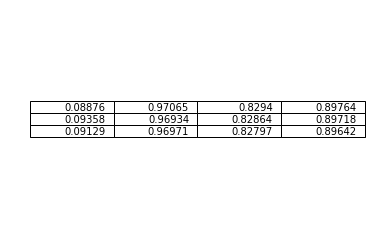

In [ ]:
plt.table(cellText=cells,loc='center')
plt.axis('off')
plt.show()